# mismatch library

# Fold change

In [1]:
# default modules
import sys
import math
import random
import pickle

In [2]:
# external modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
# increase figure resolution
plt.rcParams['figure.dpi'] = 200

In [4]:
# custom modules
import analysis_final as analysis
from SliderClass_final import Slider
import graph_final as graph

In [5]:
# working directory
path = "/home/spark159/../../media/spark159/sw/slide_seq_data(2021.07.14)/"

In [6]:
# basic parameters
tlen = 225 # sliding DNA template length
NCPlen = 147 # nucleosomal DNA length

In [7]:
# load WT 601 sliding data
WT_slider1 = pickle.load(open(path+'601_0min'+'.pickle'))['601']
WT_slider2 = pickle.load(open(path+'601_5min'+'.pickle'))['601']

In [8]:
# load mismatch library data
mismatch_sliders1 = pickle.load(open(path+'mmlib_bubble_0min_1rep'+'.pickle'))
mismatch_sliders2 = pickle.load(open(path+'mmlib_bubble_5min_1rep'+'.pickle'))

In [9]:
# set target ids
common_ids = list(set(mismatch_sliders1.keys()) & set(mismatch_sliders2.keys()))
target_ids = []
for id in common_ids:
    loc, mtype, nts = id.split('-')
    if len(nts) < 1:
        continue
    if len(nts) > 5:
        continue
    target_ids.append(id)
target_ids = sorted(target_ids, cmp=analysis.wid_cmp_len)

In [10]:
# group target ids by size
size_ids = {}
for id in target_ids:
    loc, mtype, nts = id.split('-')
    size = len(nts)
    if size not in size_ids:
        size_ids[size] = []
    size_ids[size].append(id)

In [ ]:
# group target ids by the middle of perturbation
middle_ids = {}
for id in target_ids:
    loc, mtype, nts = id.split('-')
    loc = int(loc)
    size = len(nts)
    middle = loc + size/2
    if middle not in middle_ids:
        middle_ids[middle] = []
    middle_ids[middle].append(id)

In [ ]:
# get KL divergence
middle_KLs1 = {}


In [11]:
# compute fold change of dyad signal compared to WT control
id_logratio1, id_logratio2 = {}, {}
for id in target_ids:
    psig1 = mismatch_sliders1[id].get_psig()
    psig2 = mismatch_sliders2[id].get_psig()
    WTsig1 = WT_slider1.get_psig()
    WTsig2 = WT_slider2.get_psig()
    #logratio1 = psig1
    #logratio2 = psig2
    logratio1 = np.log2((psig1+1)/(WTsig1+1))
    logratio2 = np.log2((psig2+1)/(WTsig2+1))
    id_logratio1[id] = logratio1
    id_logratio2[id] = logratio2

In [12]:
# plot dyad signal fold change around mismatch
def plot_foldchange (id_logratio, ids, title='', xlabel='', ylabel=''):
    fig = plt.figure()
    for id in ids:
        loc, mtype, nts = id.split('-')
        loc, size = int(loc), len(nts)
        middle = loc + size/2
        logratio = id_logratio[id]
        plt.plot(range(-middle, len(logratio)-middle), logratio, alpha=0.5)
    plt.title(title)                                                                                                                                                                        
    plt.xlabel(xlabel)                                                                                                                                                                    
    plt.ylabel(ylabel)                                                                                                                                                                                                                                                                                               
    plt.show()                                                                                                                                                                              
    plt.close()

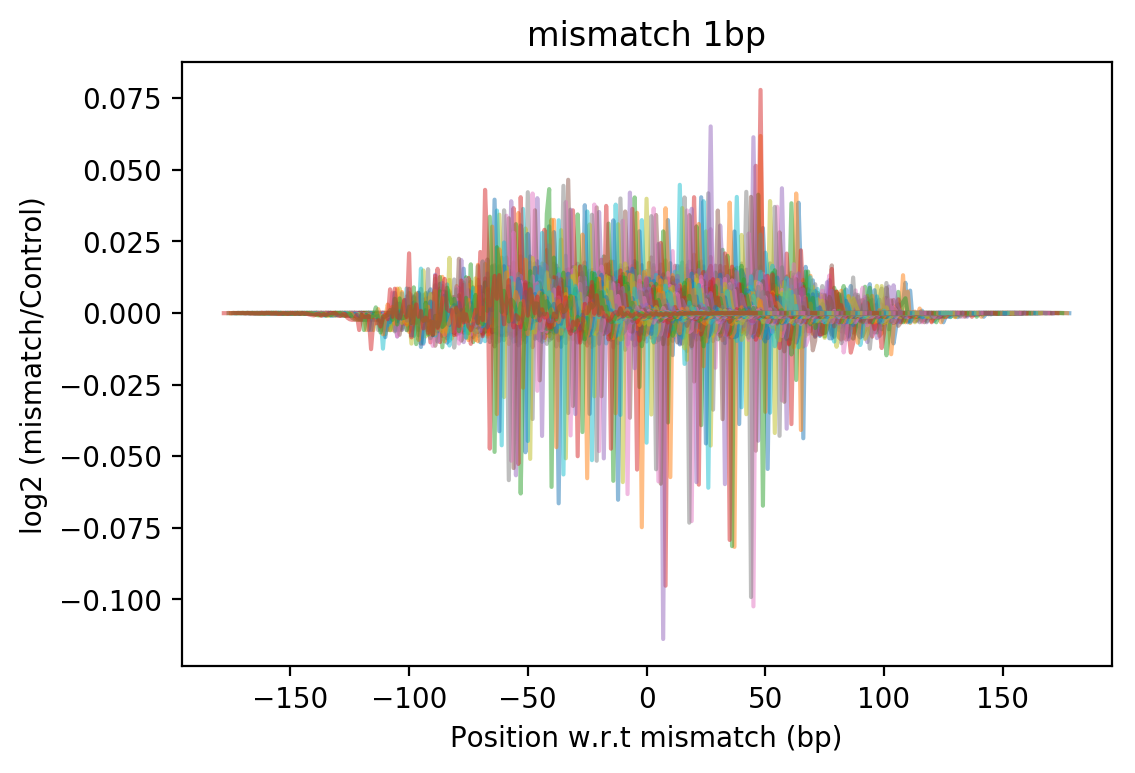

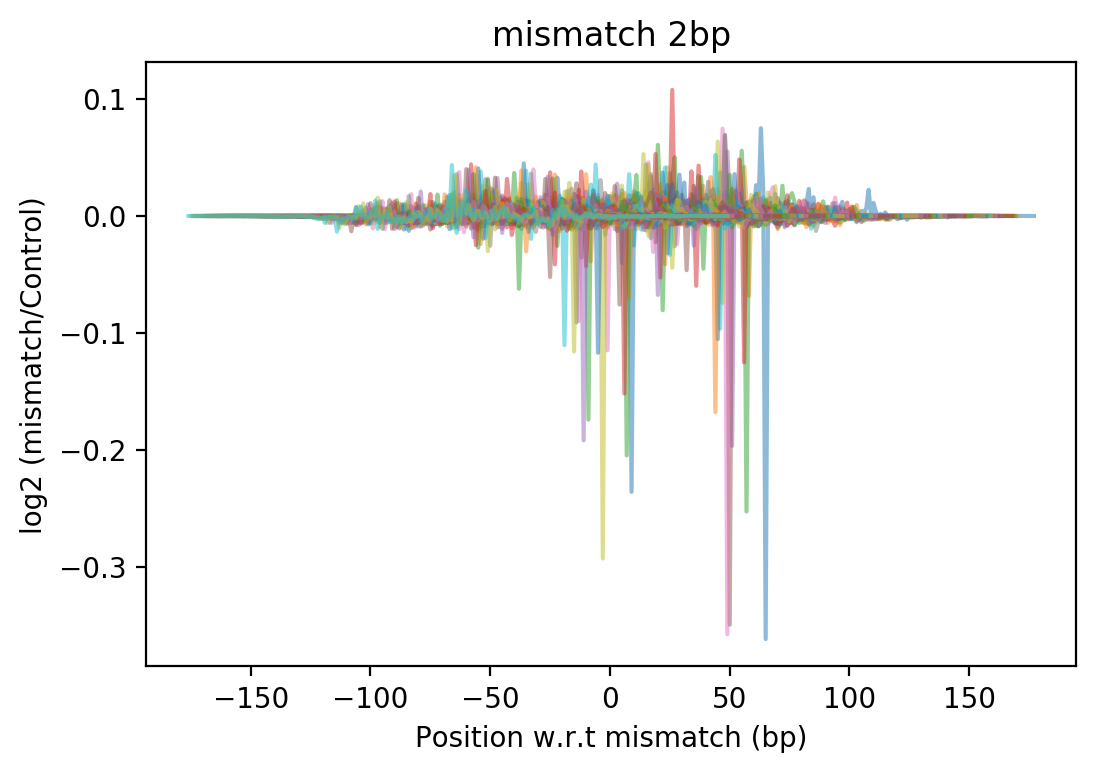

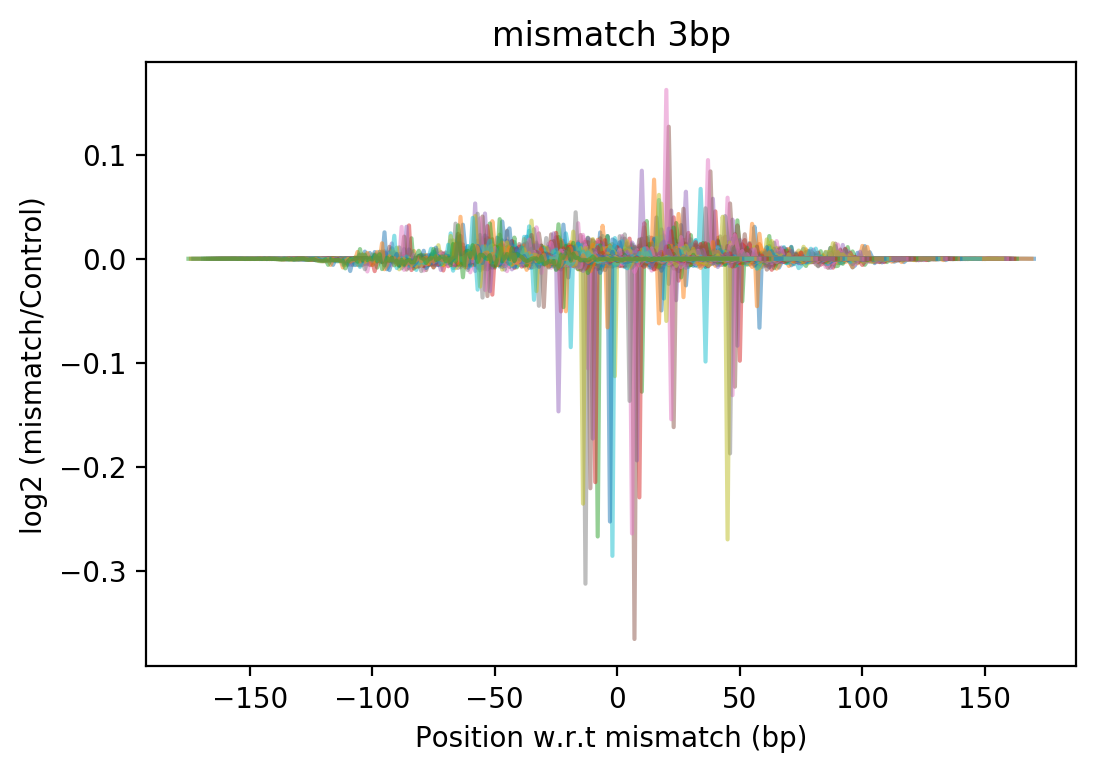

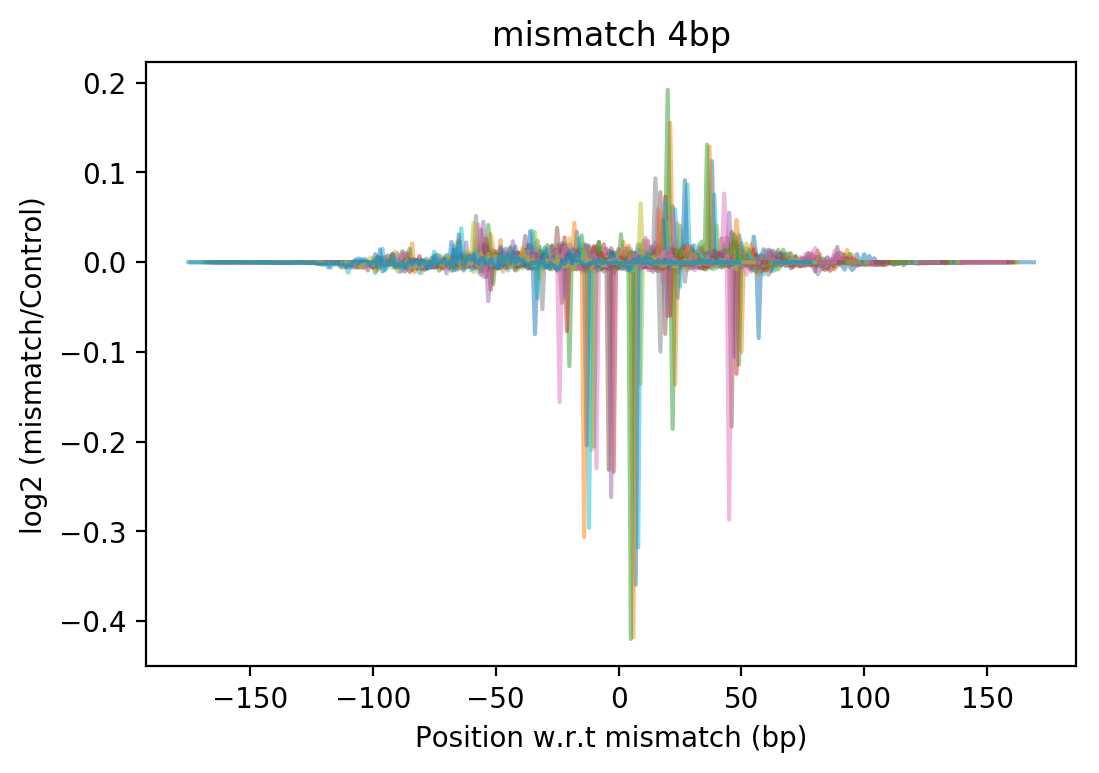

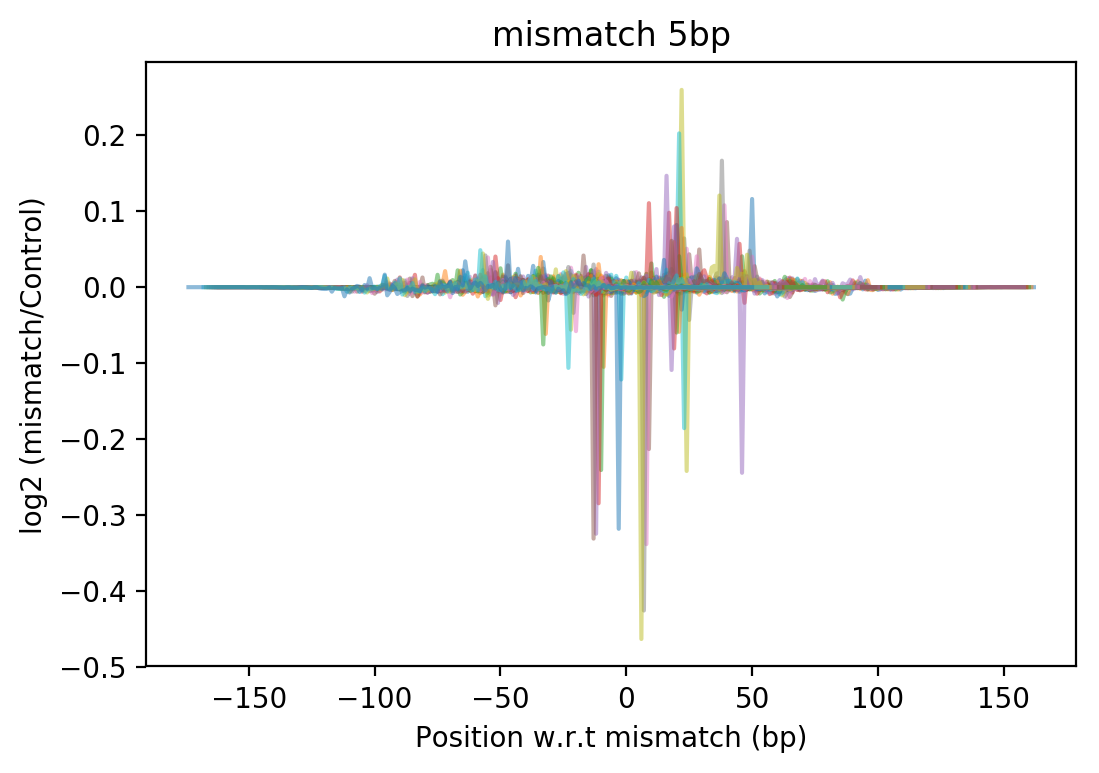

In [13]:
# Before sliding
for size, ids in size_ids.items():
    plot_foldchange(id_logratio1, ids, title="mismatch " + str(size) + "bp", xlabel="Position w.r.t mismatch (bp)", ylabel="log2 (mismatch/Control)")

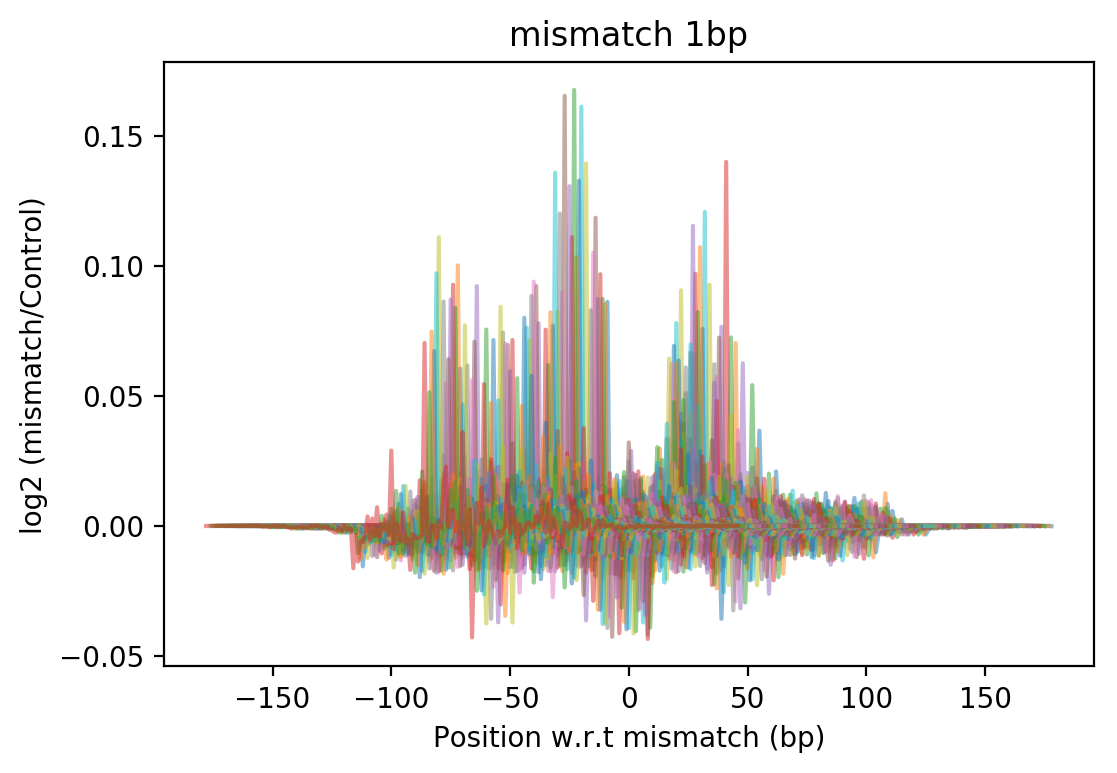

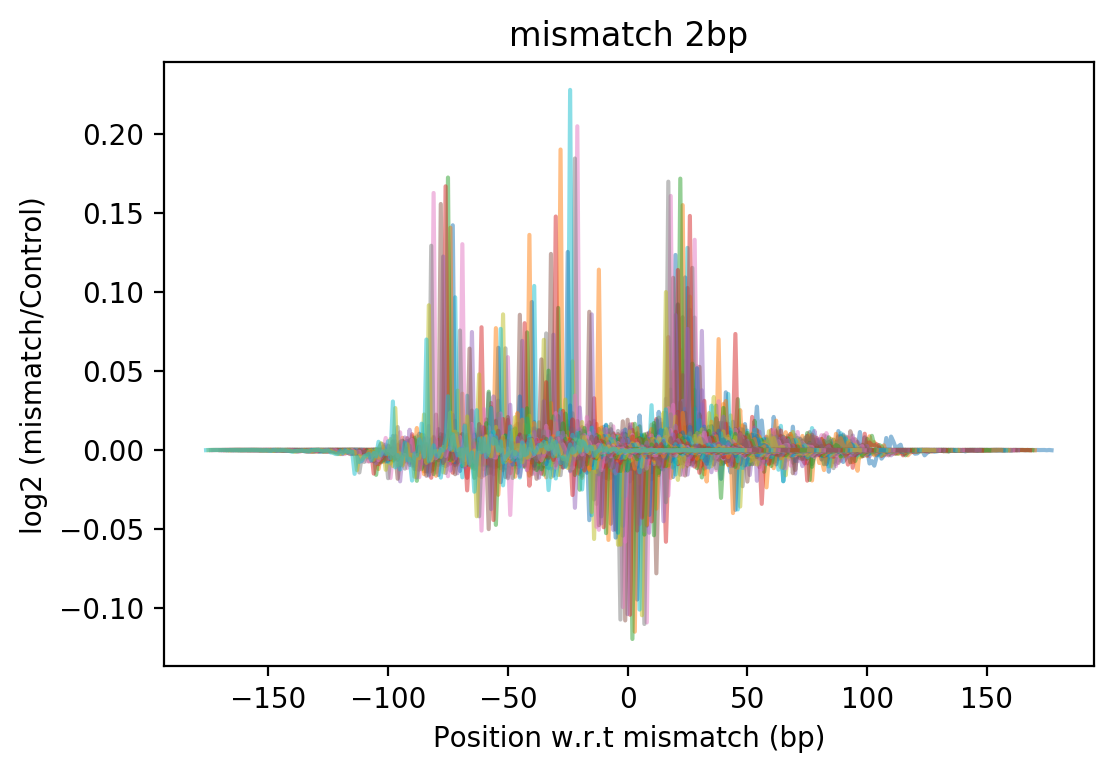

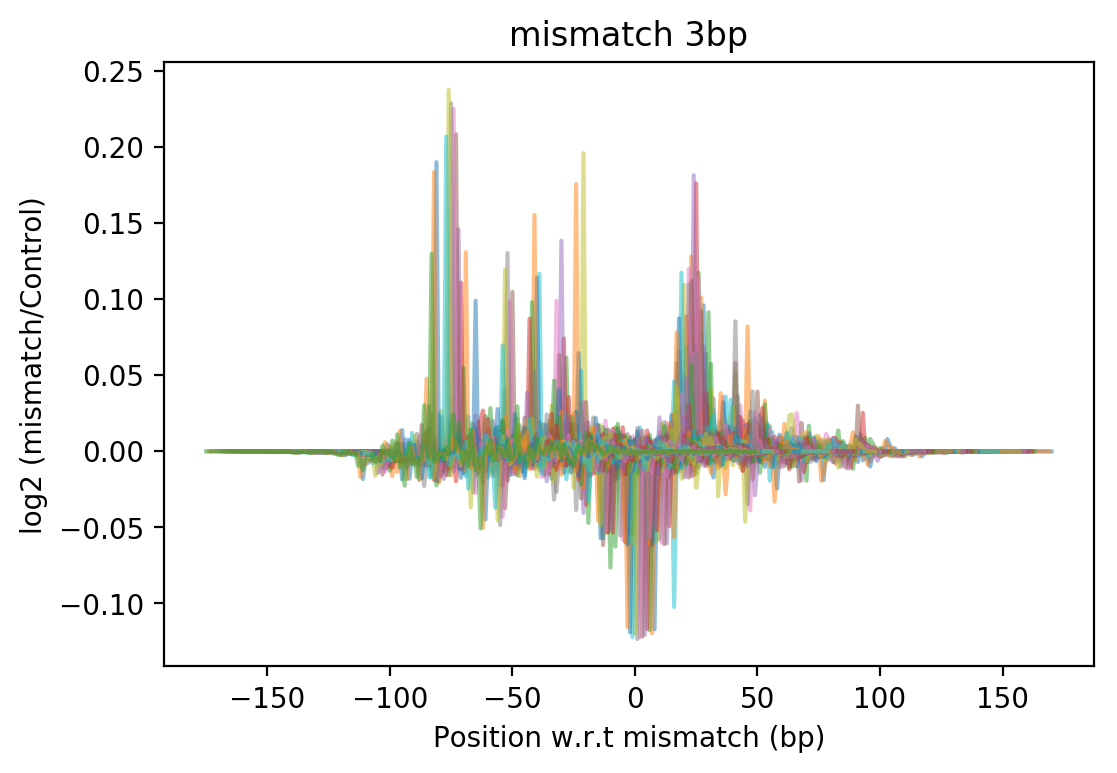

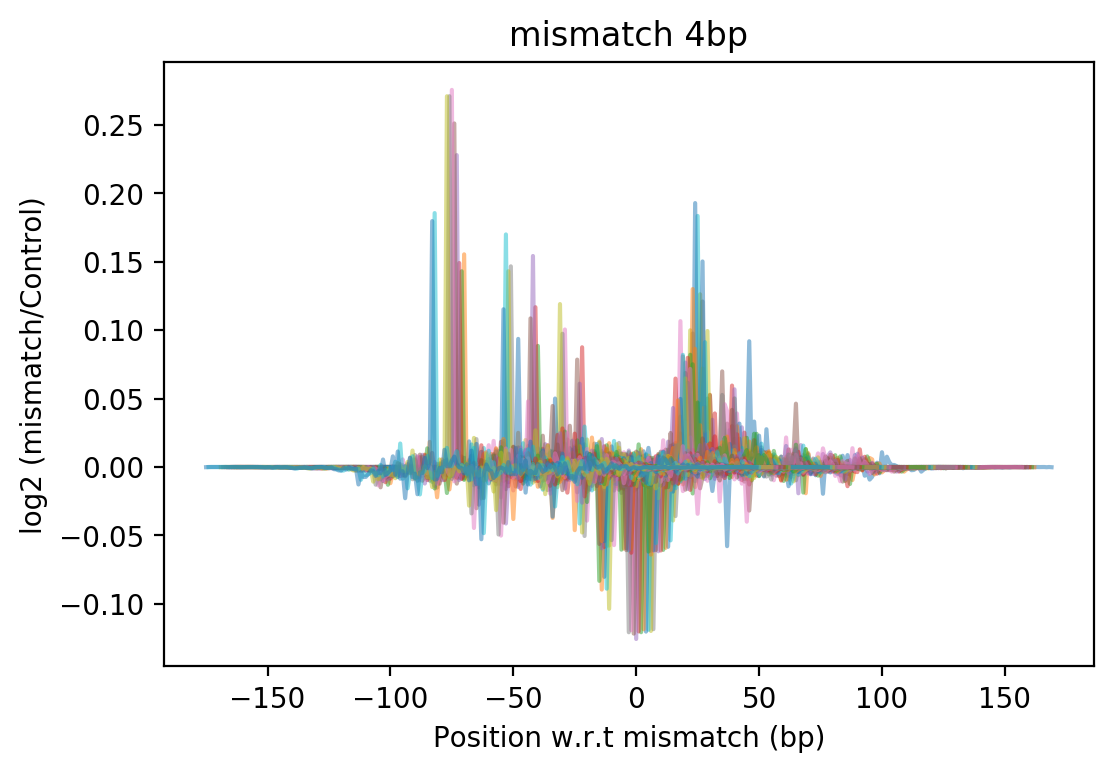

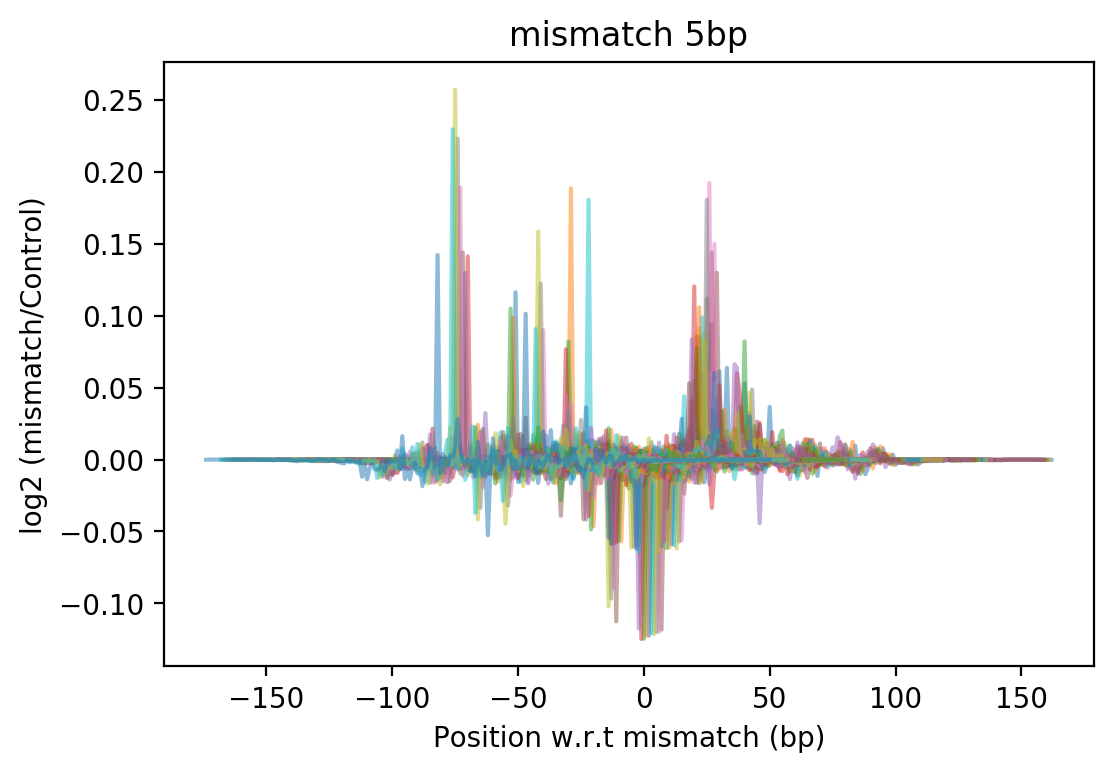

In [14]:
# After sliding
for size, ids in size_ids.items():
    plot_foldchange(id_logratio2, ids, title="mismatch " + str(size) + "bp", xlabel="Position w.r.t mismatch (bp)", ylabel="log2 (mismatch/Control)")

In [15]:
# align the fold change signal around polyA tract and group by mismatch size
sig_len = 1 + (tlen-40)*2
size_alratios1, size_alratios2 = {}, {}
for id in target_ids:
    loc, mtype, nts = id.split('-')
    loc = int(loc)
    size = len(nts)
    middle = loc + size/2
    alratio1 = [np.nan for k in range(sig_len)]
    alratio2 = [np.nan for k in range(sig_len)]   
    for i in range(tlen):
        alratio1[sig_len/2 + i-middle] = id_logratio1[id][i]
        alratio2[sig_len/2 + i-middle] = id_logratio2[id][i]
    if size not in size_alratios1:
        size_alratios1[size] = []
    if size not in size_alratios2:
        size_alratios2[size] = []
    size_alratios1[size].append(alratio1)
    size_alratios2[size].append(alratio2) 

In [16]:
# plot mean dyad signal fold change around mismatch
def plot_mean_foldchange (size_alratios):
    #color_list = ['tab:blue', 'tab:orange', 'tab:red', 'tab:green', 'tab:purple']
    cmap = cm.get_cmap('jet')
    color_list = np.linspace(0, 1, num=len(size_alratios))
    zorder_list = range(len(size_alratios))[::-1]
    #fig = plt.figure()
    for i in range(len(size_alratios)):
        fig = plt.figure()
        size = sorted(size_alratios.keys())[i]
        mean_alratio = np.nanmean(size_alratios[size], axis=0)
        #max_alratio = np.nanmax(size_alratios[size], axis=0)
        #min_alratio = np.nanmin(size_alratios[size], axis=0)
        plt.plot(range(-(tlen-40), tlen-40+1), mean_alratio, alpha=0.5, color=cmap(color_list[i]), label=size)
        #plt.plot(range(-(tlen-40), tlen-40+1), min_alratio, alpha=0.3, color=cmap(color_list[i]))
        #plt.plot(range(-(tlen-40), tlen-40+1), max_alratio, alpha=0.3, color=cmap(color_list[i]))
        #plt.fill_between(range(-(tlen-40), tlen-40+1), min_alratio, max_alratio, color=cmap(color_list[i]), alpha=0.2, zorder=zorder_list[i], label=size)                                                                                                                                                                    
        plt.xlabel("Position w.r.t mismatch (bp)")                                                                                                                                     
        plt.ylabel("log2 (mismatch/Control)")
        plt.legend()
        plt.show()                                                                                                                                                                              
        plt.close()

Before sliding


/home/spark159/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


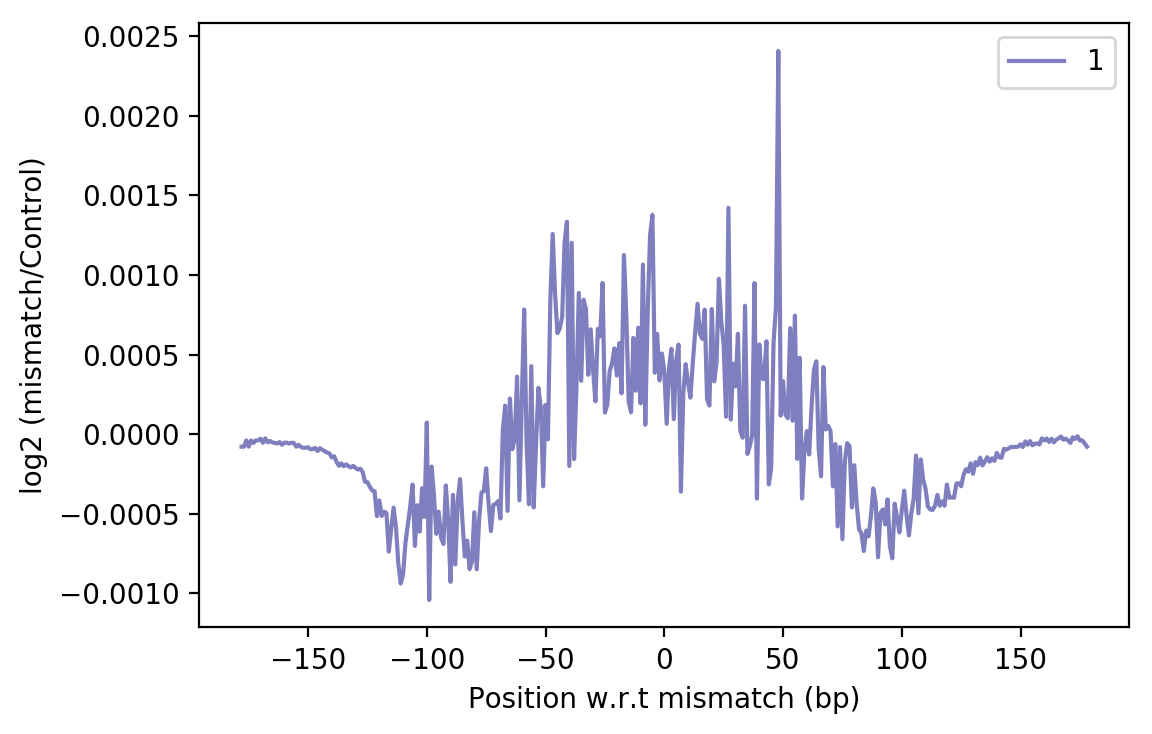

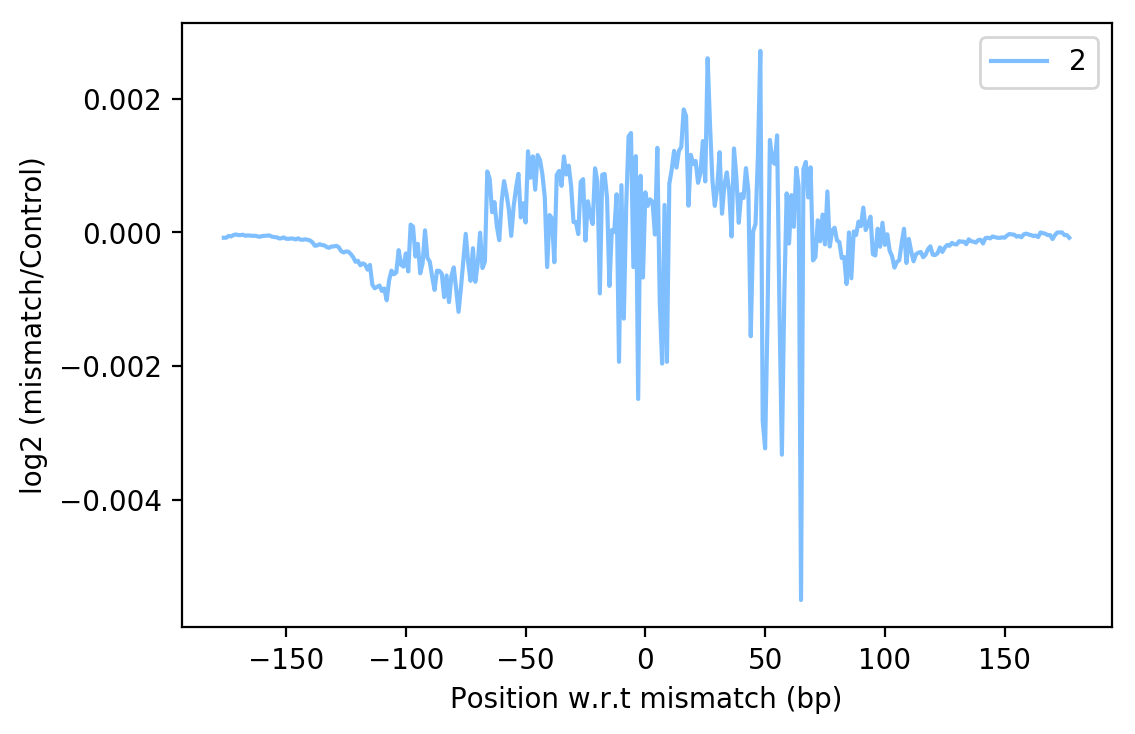

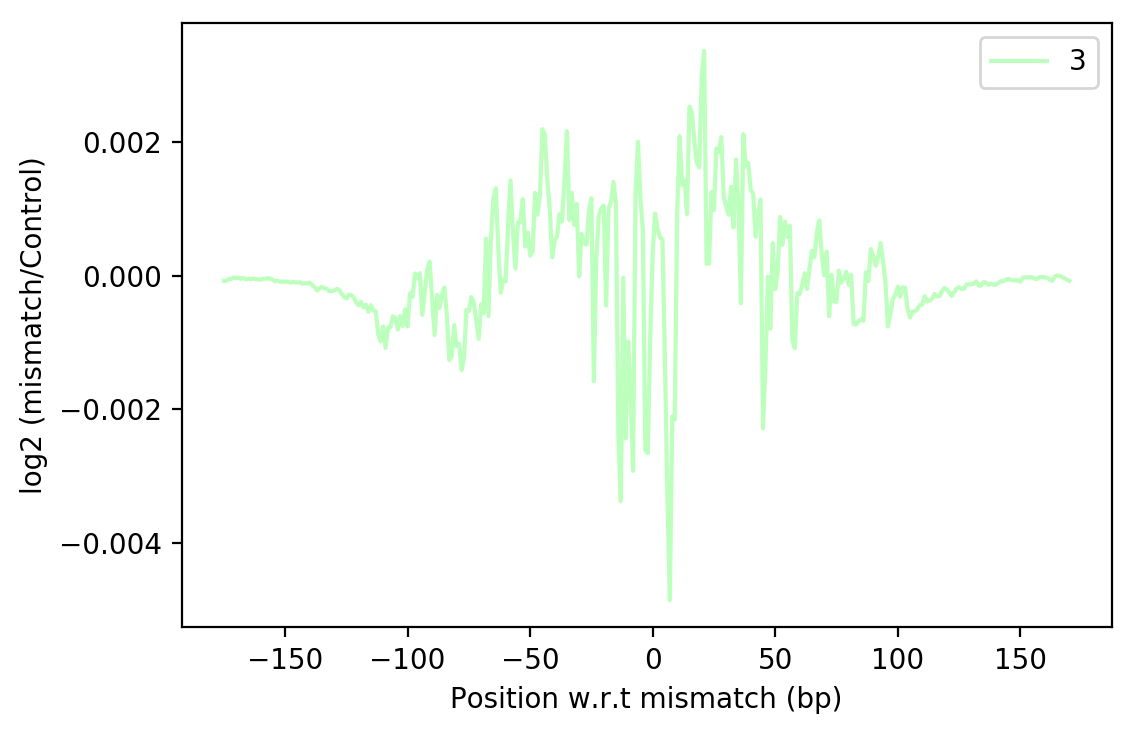

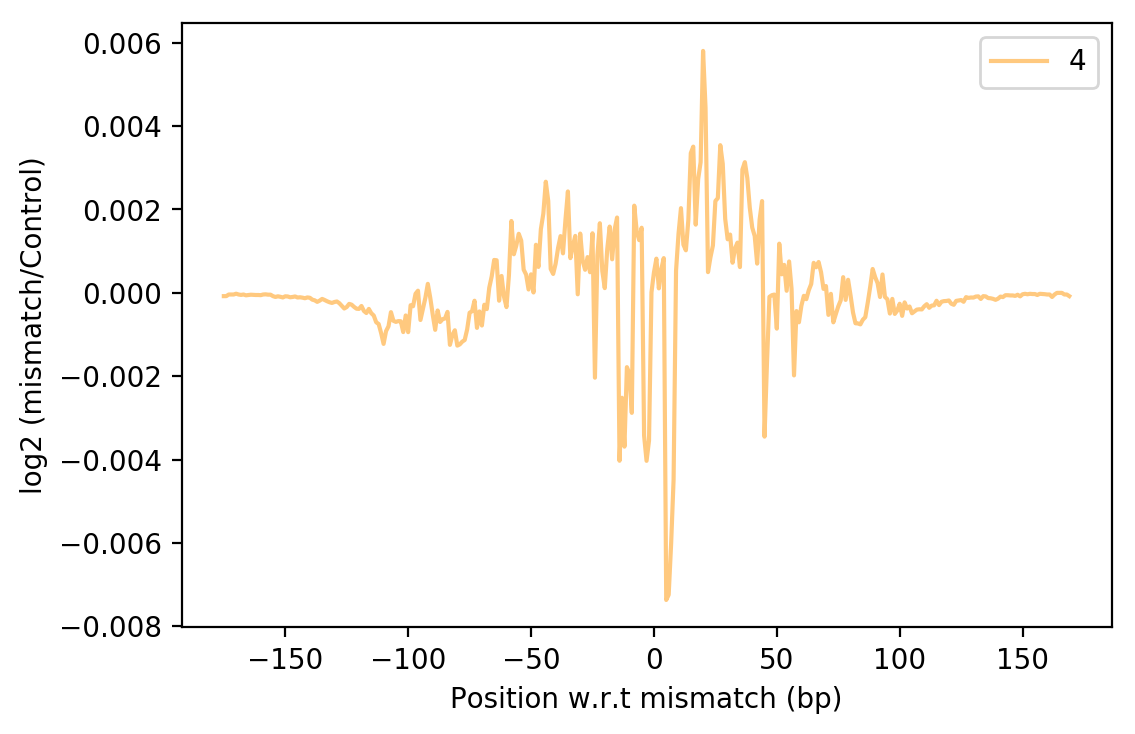

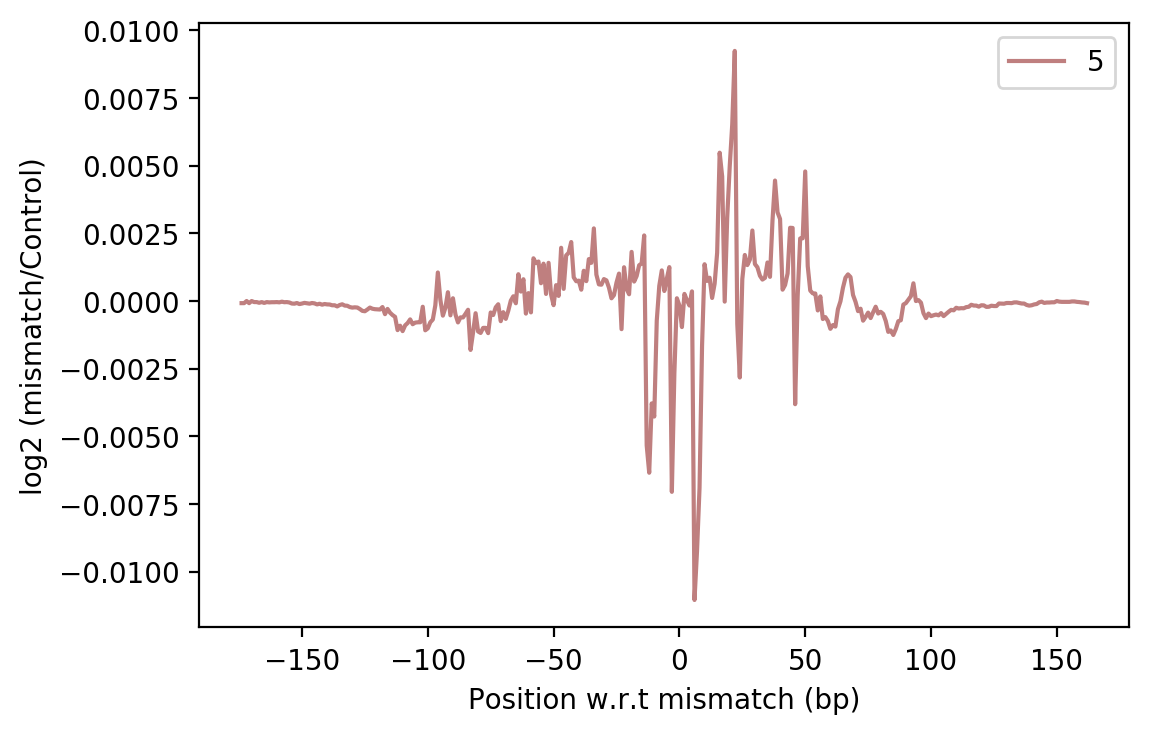

In [17]:
print "Before sliding"
plot_mean_foldchange(size_alratios1)

After sliding


/home/spark159/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


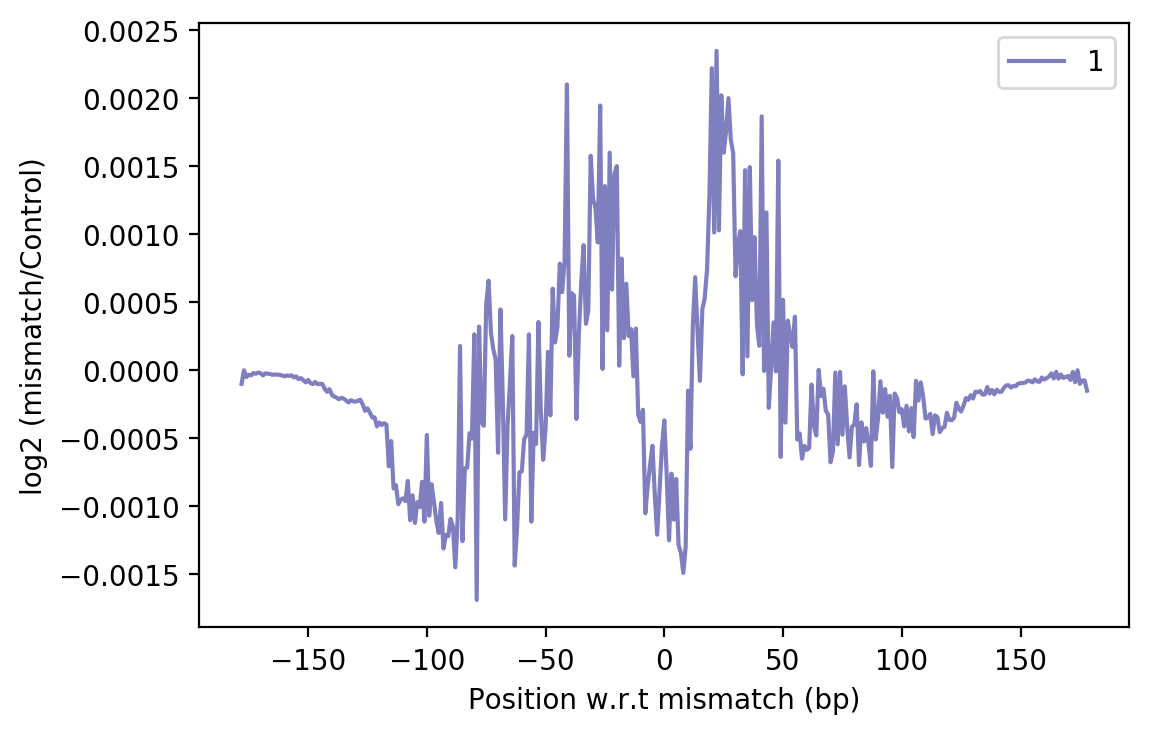

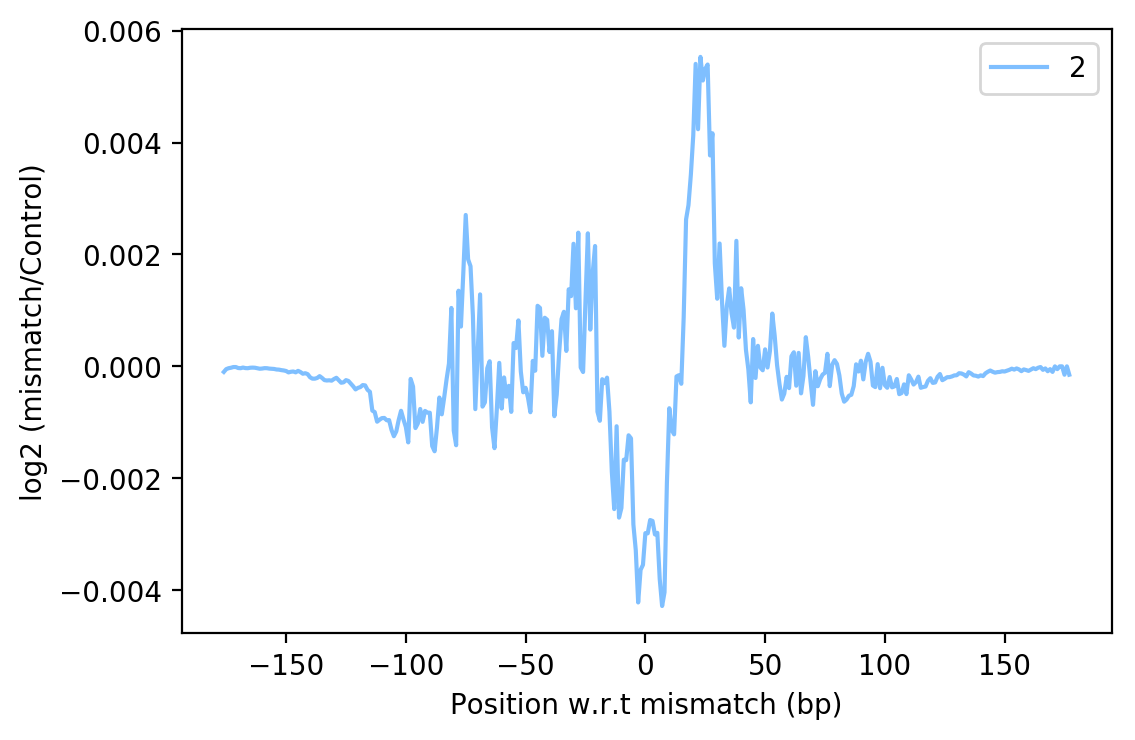

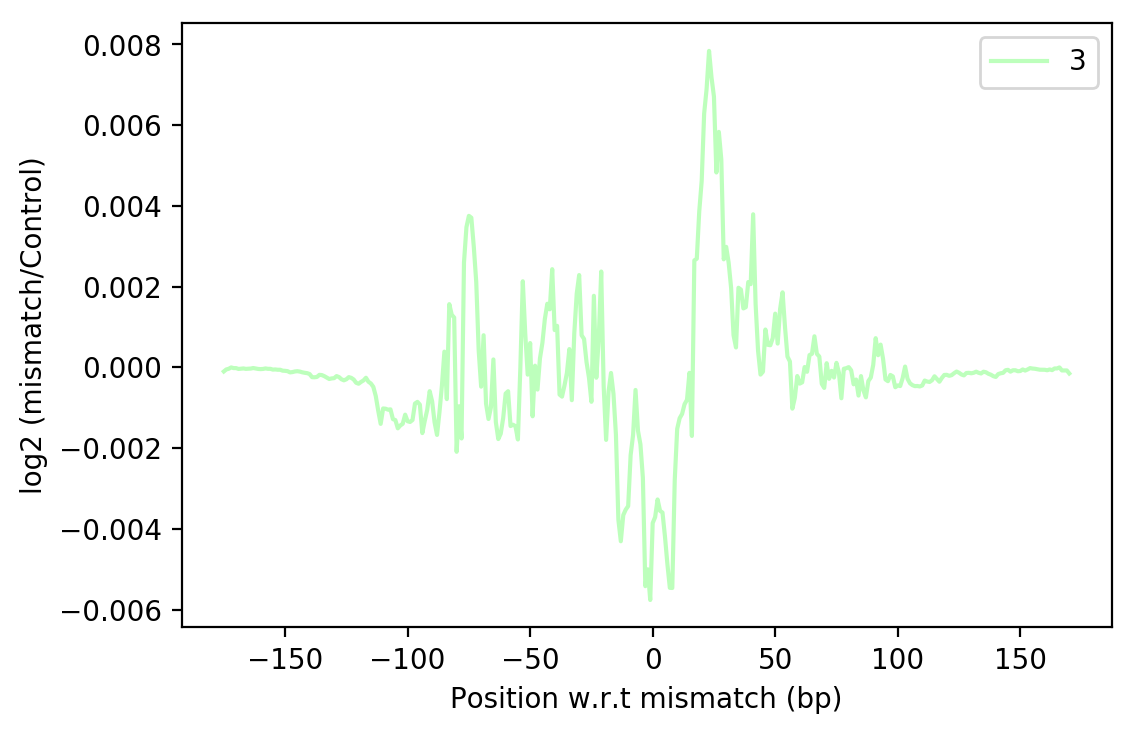

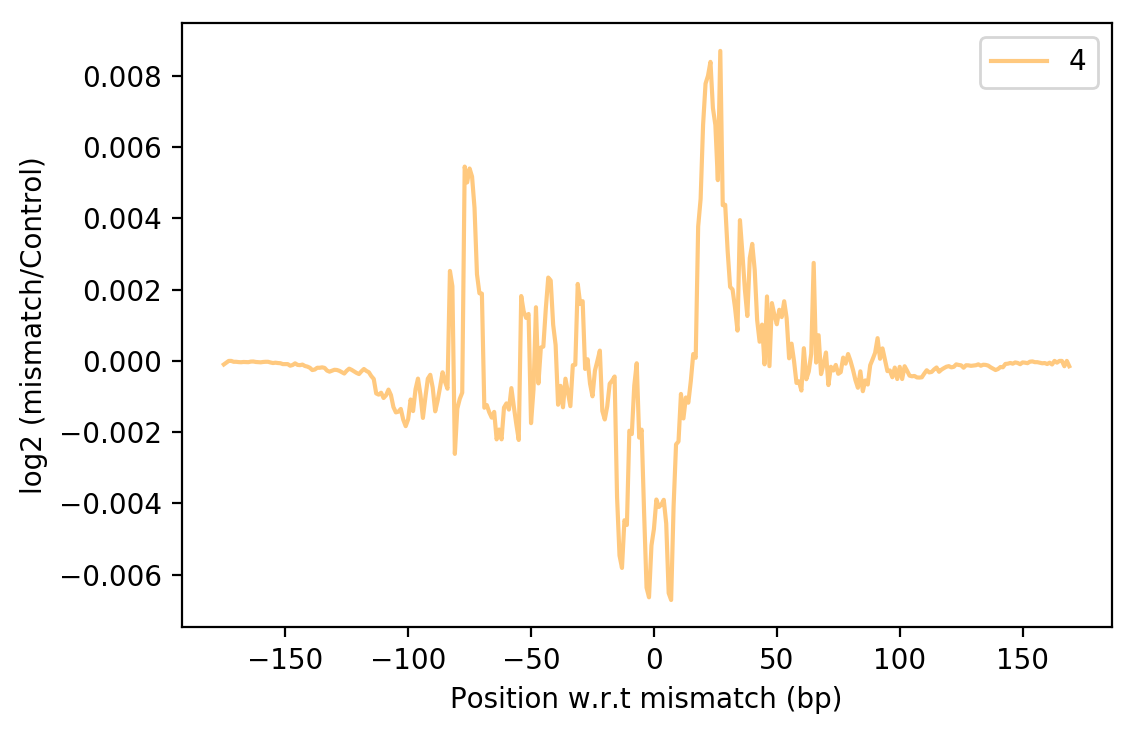

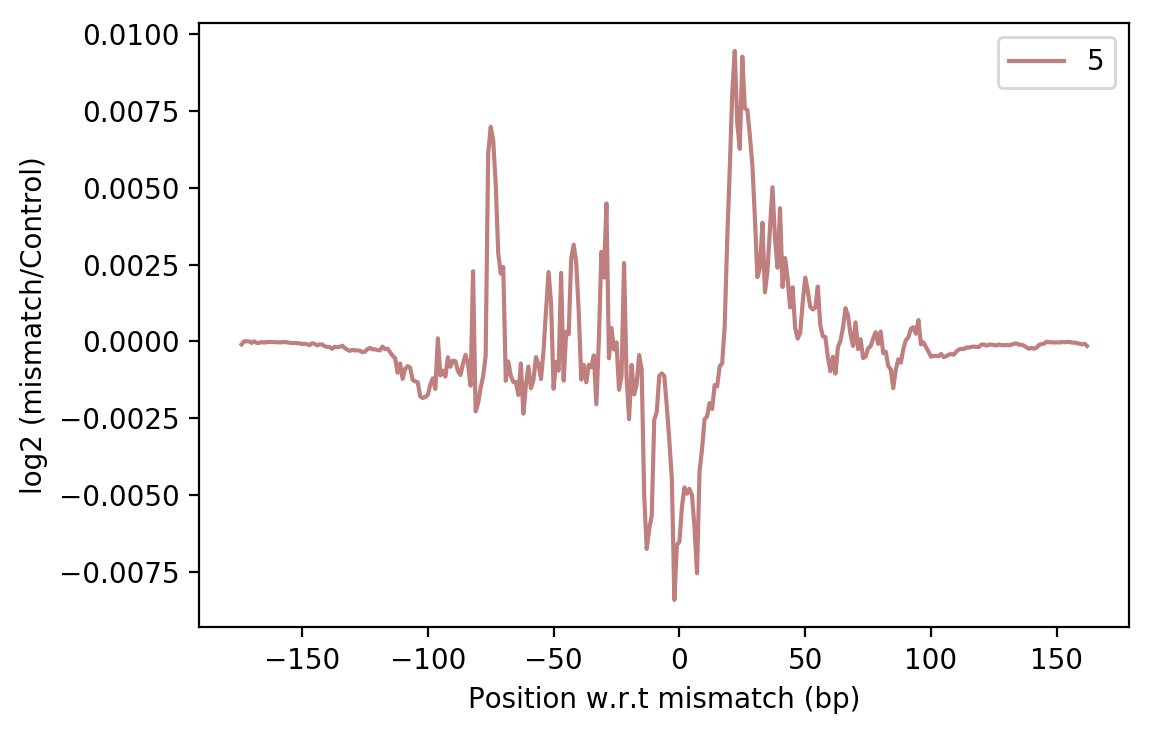

In [18]:
print "After sliding"
plot_mean_foldchange(size_alratios2)